# IMPORTS

In [5]:
!pip install tensorflow
!pip install albumentations
!pip install --upgrade tensorflow

In [7]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,Dense,Dropout,BatchNormalization,Flatten,MaxPool2D,MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50,DenseNet121,EfficientNetB2,VGG19
from tensorflow.keras import layers
from tensorflow.keras import Model
import cv2

Mounted at /content/drive


# DATA Download

In [8]:
!rm -r "/content/oral-cancer-dataset.zip" #if already exists delete

rm: cannot remove '/content/oral-cancer-dataset.zip': No such file or directory


In [9]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json     #giving permission
!kaggle datasets download -d zaidpy/oral-cancer-dataset
!unzip "/content/oral-cancer-dataset.zip" -d "/content/dataset/"  # UNZIP

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/zaidpy/oral-cancer-dataset
License(s): apache-2.0
 98% 309M/315M [00:02<00:00, 161MB/s]
100% 315M/315M [00:02<00:00, 137MB/s]
Archive:  /content/oral-cancer-dataset.zip
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/001.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/002.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/003.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/004.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/005.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/006.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/007.jpeg  
  inflating: /content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER/008.jpeg  
  inflating: 

# DATA MANAGEMENT

## Changing data

there are two folders so we are just shifting from old to the new dir

In [10]:
#Renaming Folder
import os
os.rename("/content/dataset/Oral Cancer/Oral Cancer Dataset/CANCER","/content/dataset/Oral Cancer/Oral Cancer Dataset/cancer")
os.rename("/content/dataset/Oral Cancer/Oral Cancer Dataset/NON CANCER","/content/dataset/Oral Cancer/Oral Cancer Dataset/non cancer")

import shutil
folder_path ="/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER"
os.chdir(folder_path)
files = os.listdir()
lis=[str(file) for file in files]
for i in lis:
  os.rename("/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/"+i,"/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/"+str(0)+i)


folder_path ="/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER"
os.chdir(folder_path)
files = os.listdir()
lis=[file for file in files]
for i in lis:
  os.rename("/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER/"+i,"/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER/"+str(0)+i)


In [11]:
#moving files
folder_path ="/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER"
os.chdir(folder_path)
files = os.listdir()
lis=[str(file) for file in files]
for i in lis:
    shutil.move("/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/CANCER/"+i,"/content/dataset/Oral Cancer/Oral Cancer Dataset/cancer")

folder_path ="/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER"
os.chdir(folder_path)
files = os.listdir()
lis=[file for file in files]
for i in lis:
    shutil.move("/content/dataset/Oral cancer Dataset 2.0/OC Dataset kaggle new/NON CANCER/"+i,"/content/dataset/Oral Cancer/Oral Cancer Dataset/non cancer")

In [12]:
#delete corrupt fies
import os
import imghdr
count=0
path = "/content/dataset/Oral Cancer/Oral Cancer Dataset/cancer"
dir_ = os.listdir(path)
for image in dir_:
    file = os.path.join(path,image)
    if not imghdr.what(file):
        count=count+1
        os.remove(file)

path = "/content/dataset/Oral Cancer/Oral Cancer Dataset/non cancer"
dir_ = os.listdir(path)
for image in dir_:
    file = os.path.join(path,image)
    if not imghdr.what(file):
        count=count+1
        os.remove(file)
print("Corrupt files are {}".format(count))

Corrupt files are 24


In [13]:
!rm -r "/content/dataset/Oral cancer Dataset 2.0" #delete after empty
# !rm -r "/content/dataset"

## process DATA

In [ ]:
def load_data(folder_path):
    images = []
    labels = []
    for label, category in enumerate(['cancer', 'non cancer']):
        category_folder = os.path.join(folder_path, category)
        for file_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, file_name)
            image = load_img(image_path, target_size=(224, 224))  # Adjust target size as needed
            image_array = img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

folder_path = "/content/dataset/Oral Cancer/Oral Cancer Dataset"
images, labels = load_data(folder_path)


# Models

## 1. Resnet_50

In [ ]:
# Split data into train and test sets using skit-learn
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=100, shuffle=True)

# Define and compile the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the ResNet-50 base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)  # bin classification

model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

model_resnet50.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) #reduce overfitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001) # pateince
checkpoint_filepath = '/content/best_model_resnet.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,      # Only save the best model
    mode='max',               # Save the model when the monitored quantity is maximized
    verbose=1
)

In [ ]:
model_resnet50.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,686,913 (97.99 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(1340, 224, 224, 3)
(336, 224, 224, 3)


In [ ]:
# Train the model
history = model_resnet50.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.7131 - loss: 1.6270 - precision_1: 0.6704 - recall_1: 0.6345
Epoch 1: val_accuracy improved from -inf to 0.89881, saving model to /content/best_model_resnet.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 456ms/step - accuracy: 0.7152 - loss: 1.6075 - precision_1: 0.6727 - recall_1: 0.6375 - val_accuracy: 0.8988 - val_loss: 0.2529 - val_precision_1: 0.9027 - val_recall_1: 0.8160 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9217 - loss: 0.2194 - precision_1: 0.9149 - recall_1: 0.8864
Epoch 2: val_accuracy did not improve from 0.89881
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.9216 - loss: 0.2191 - precision_1: 0.9149 - recall_1: 0.8866 - val_accuracy: 0.8810 - val_loss: 0.2807 - val_precision_1: 0.7742 - val_recall_1: 0.9600 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9339 - loss: 0.1593 - precision_1: 0.9259 - recall_1: 0.9166
Epoch

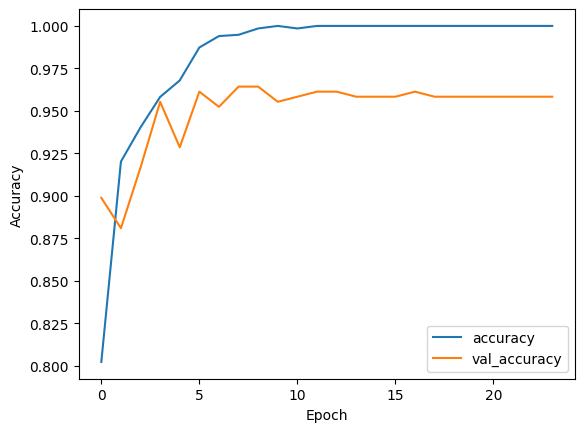

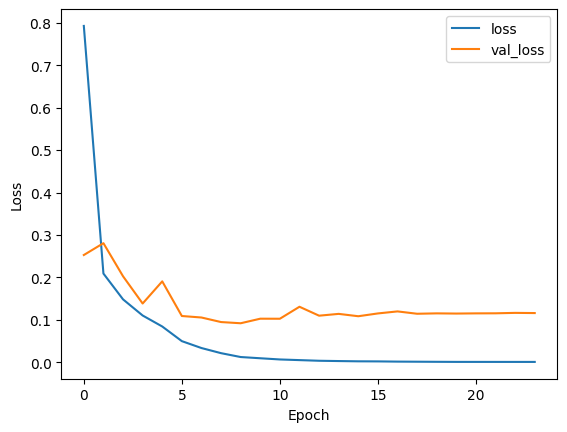

In [ ]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
model_resnet50.evaluate(X_test,y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9627 - loss: 0.1047 - precision_1: 0.9687 - recall_1: 0.9297


[0.0921875610947609,
 0.9642857313156128,
 0.9448819160461426,
 0.9599999785423279]

### Loading and Testing

In [ ]:
new_model_resnet50 = tf.keras.models.load_model('/content/best_model_resnet.keras')

# Show the model architecture
new_model_resnet50.summary()

In [ ]:
new_model_resnet50.evaluate(X_test,y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.9627 - loss: 0.1051 - precision_1: 0.9687 - recall_1: 0.9297


[0.09500525891780853,
 0.9642857313156128,
 0.9448819160461426,
 0.9599999785423279]

### TESTING

0- cancer, 0.4< non cancer

In [ ]:
CLASS_NAMES=['cancer','non cancer']
test_img=cv2.imread("/content/dataset/Oral Cancer/Oral Cancer Dataset/cancer/047.jpeg")
test_img= cv2.resize(test_img,(224,224))
test_img= tf.expand_dims(test_img,axis=0)
print(CLASS_NAMES[tf.argmax(new_model_resnet50(test_img),axis=-1).numpy()[0]])
model_resnet50.predict(test_img)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


0.0019480351

## 2. EfficientNetB2

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=97, shuffle=True)

# Define and compile the model
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

model_EfficientNetB2 = Model(inputs=base_model.input, outputs=predictions)

model_EfficientNetB2.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
checkpoint_filepath = '/content/efficient_net_B2.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,      # Only save the best model
    mode='max',               # Save the model when the monitored quantity is maximized
    verbose=1
)

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history = model_EfficientNetB2.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - accuracy: 0.8363 - loss: 0.3900 - precision_2: 0.8274 - recall_2: 0.7471
Epoch 1: val_accuracy improved from -inf to 0.92262, saving model to /content/efficient_net_B2.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8371 - loss: 0.3884 - precision_2: 0.8280 - recall_2: 0.7487 - val_accuracy: 0.9226 - val_loss: 0.2108 - val_precision_2: 0.9342 - val_recall_2: 0.8987 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9173 - loss: 0.1950 - precision_2: 0.9032 - recall_2: 0.8845
Epoch 2: val_accuracy did not improve from 0.92262
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 88ms/step - accuracy: 0.9175 - loss: 0.1944 - precision_2: 0.9036 - recall_2: 0.8848 - val_accuracy: 0.9226 - val_loss: 0.1897 - val_precision_2: 0.8976 - val_recall_2: 0.9430 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9604 - loss: 0.1257 - precision_2: 0.9433 - recall_2: 0.9584
Epoch 3: 

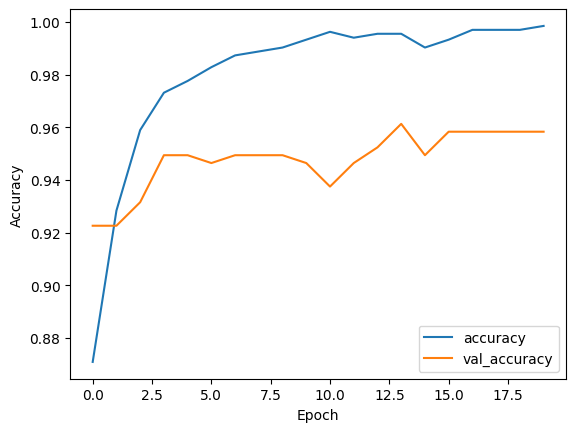

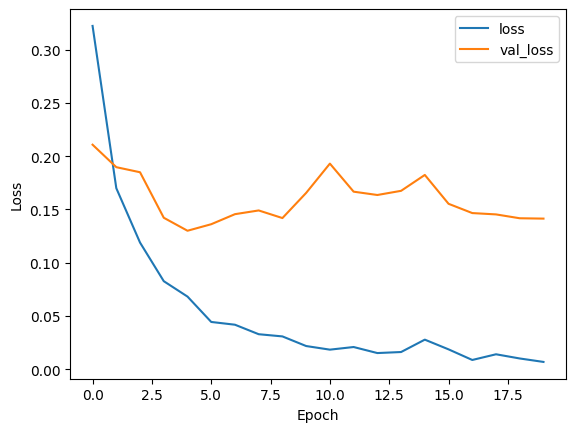

In [ ]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
model_EfficientNetB2.evaluate(X_test,y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9488 - loss: 0.1045 - precision_2: 0.9529 - recall_2: 0.9441


[0.13002176582813263, 0.949404776096344, 0.9433962106704712, 0.949367105960846]

### Testing

0-cancer 0.4<-non cancer

In [ ]:
# test_img=cv2.imread("/content/dataset/Oral Cancer/Oral Cancer Dataset/cancer/005.jpeg")   #cancer
test_img=cv2.imread("/content/dataset/Oral Cancer/Oral Cancer Dataset/non cancer/003.jpeg")  #non cancer
test_img= cv2.resize(test_img,(224,224))
test_img= tf.expand_dims(test_img,axis=0)
model_EfficientNetB2.predict(test_img)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


0.70112276

## 3. VGG 19

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=12, shuffle=True)

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)  # Adding dropout for regularization
predictions = layers.Dense(1, activation='sigmoid')(x)

model_VGG19 = Model(inputs=base_model.input, outputs=predictions)
model_VGG19.compile(loss='binary_crossentropy',metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()],optimizer='adam')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
checkpoint_filepath = '/content/vgg19.keras'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',  # Save the model based on validation accuracy
    save_best_only=True,      # Only save the best model
    mode='max',               # Save the model when the monitored quantity is maximized
    verbose=1
)

In [ ]:
# Train the model
history = model_VGG19.fit(
    x= X_train,
    y= y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr,checkpoint]
)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.7718 - loss: 1.2204 - precision_1: 0.7198 - recall_1: 0.7233
Epoch 1: val_accuracy improved from -inf to 0.90179, saving model to /content/vgg19.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 24s 422ms/step - accuracy: 0.7730 - loss: 1.2171 - precision_1: 0.7213 - recall_1: 0.7248 - val_accuracy: 0.9018 - val_loss: 0.4372 - val_precision_1: 0.8675 - val_recall_1: 0.9097 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8637 - loss: 0.7421 - precision_1: 0.8459 - recall_1: 0.8290
Epoch 2: val_accuracy improved from 0.90179 to 0.91369, saving model to /content/vgg19.keras
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - accuracy: 0.8638 - loss: 0.7407 - precision_1: 0.8458 - recall_1: 0.8292 - val_accuracy: 0.9137 - val_loss: 0.4369 - val_precision_1: 0.9389 - val_recall_1: 0.8542 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9211 - loss: 0.2990 - precision_1

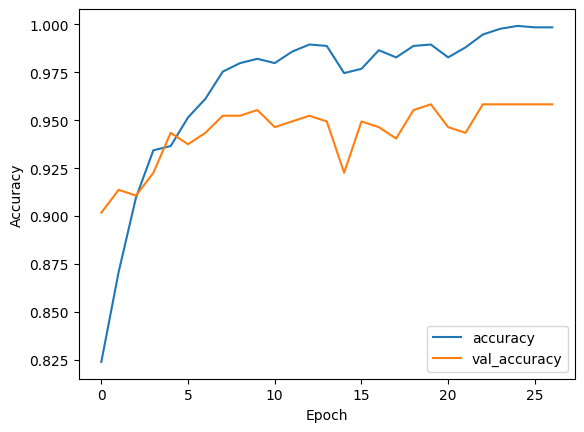

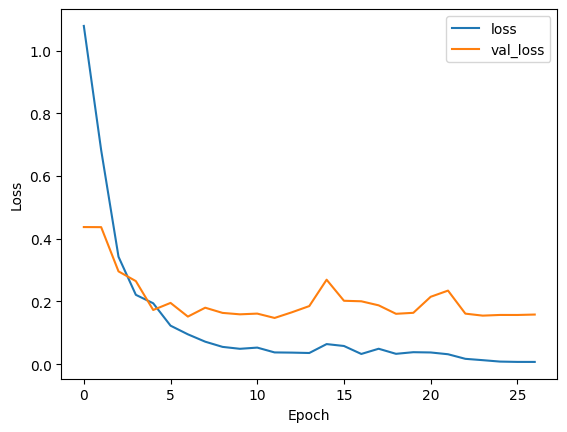

In [ ]:
# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

### test

In [ ]:
validation_dataset=(X_test,y_test)
CLASS_NAMES=["CANCER","NON CANCER"]

In [ ]:
new_model_vgg19 = tf.keras.models.load_model('/content/vgg19.keras')

# Show the model architecture
new_model_vgg19.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,603,397 (82.41 MB)

 Trainable params: 526,337 (2.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 1,052,676 (4.02 MB)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(validation_dataset)

In [ ]:
dataset.as_numpy_iterator()

NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7fc5ca759e10>)

In [ ]:
len(list(dataset.as_numpy_iterator()))

336

In [ ]:
def prediction_to_name(data):
  if(data>0.4):  #threshold =0.4
    return 1
  else:
    return 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


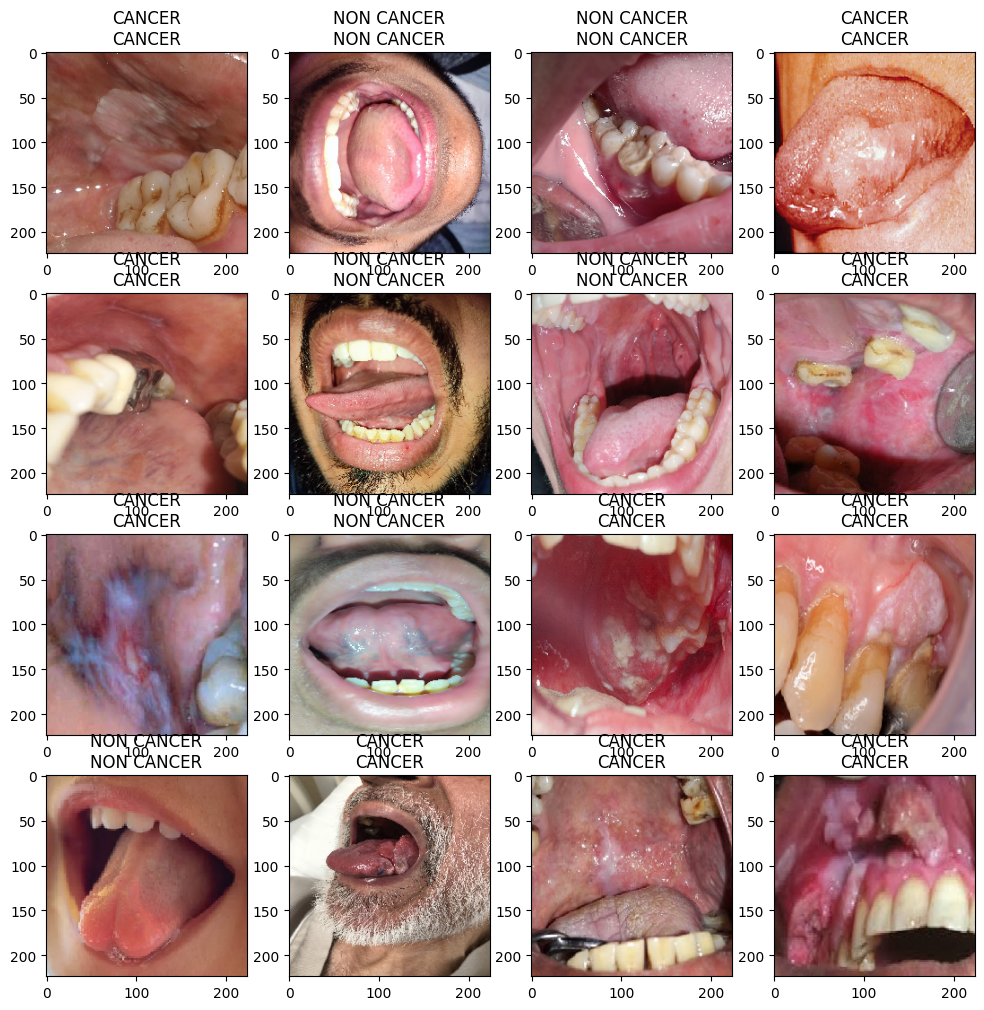

In [ ]:
plt.figure(figsize=(12,12))
for i, (image,label) in enumerate(dataset.take(16)):  #i= 1-16
  ax=plt.subplot(4,4,i+1)
  plt.imshow(image/255.0)
    # plt.imshow(np.clip(image, 0, 1))
  # plt.title(dataset_info.features['label'].int2str(label))
  plt.title(CLASS_NAMES[label] + "\n"+ CLASS_NAMES[prediction_to_name(new_model_vgg19.predict(np.expand_dims(image, axis=0))[0][0])])